In [1]:
cd c:\Users\seand\OneDrive\Dokumente\Masterthesis\CL_PDE_Solv

c:\Users\seand\OneDrive\Dokumente\Masterthesis\CL_PDE_Solv


In [2]:
from Problems.oneDim_Problems.sintsin2tproblem import clustering, f, exact_sol, clustering_grid
from models_code.SubproblemNetworks.LocalDeepONet_oneDim import LocalDeepONet_oneDim
from models_code.lossfunc import *
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path

from src.config import *

# Plots of Problem defining functions

<function matplotlib.pyplot.show(close=None, block=None)>

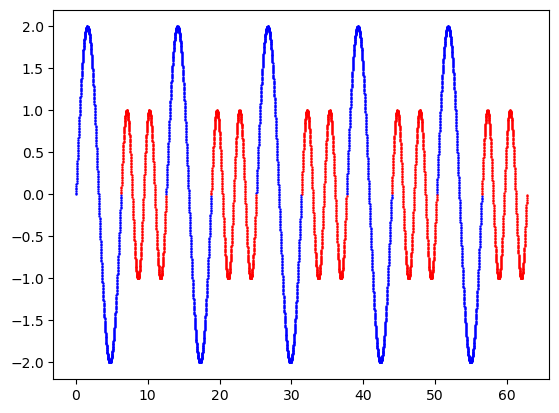

In [3]:
#plot f in [0,20 pi]
grid_x = torch.arange(0,20* np.pi,0.01)
out_f = np.array([f(t).numpy() for t in grid_x])
clusterlabel = clustering_grid(grid_x)[:,0]
plt.scatter(grid_x.numpy()[clusterlabel == 0] , out_f[clusterlabel == 0], color = 'blue', s = 0.5)
plt.scatter(grid_x.numpy()[clusterlabel == 1] , out_f[clusterlabel == 1], color = 'red', s = 0.5)
#plt.plot(grid_x.numpy() , out_f)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

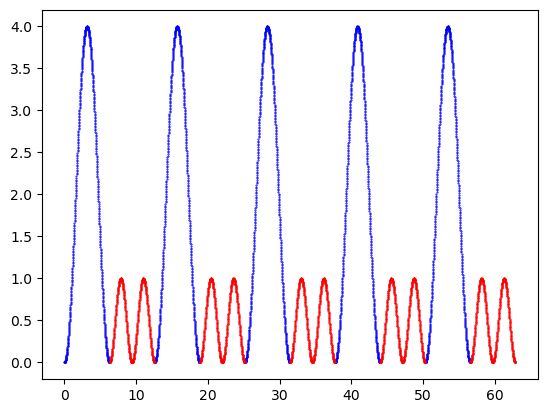

In [4]:
#plot exact solution in [0,20 pi]
grid_x = torch.arange(0,20* np.pi,0.01)
out_exact_sol = np.array([exact_sol(t).numpy() for t in grid_x])
clusterlabel = clustering_grid(grid_x)[:,0]
plt.scatter(grid_x.numpy()[clusterlabel == 0] , out_exact_sol[clusterlabel == 0], color = 'blue', s = 0.2)
plt.scatter(grid_x.numpy()[clusterlabel == 1] , out_exact_sol[clusterlabel == 1], color = 'red', s = 0.2)
plt.show

# Training Loops Local Solutions

### Domain A

In [ ]:
#load local model A
sol_cluster_A = torch.load(Path(trained_models_address , 'local_A0.pt'))
sol_cluster_A.eval()

In [ ]:
#define Trainingset on A:
num_train_boundary = 15
t_grid = torch.linspace(0.,2*torch.pi,4000,requires_grad = True).view(-1,1).to('cuda')
boundary_t = torch.tensor(0., requires_grad = True).view(-1,1).to('cuda')
boundary_values = torch.linspace(-1.5,1.5,num_train_boundary, requires_grad = True).to('cuda')
#output on grid:
f_out = torch.zeros(t_grid.shape[0]).to('cuda')
for i in range(t_grid.shape[0]):
  f_out[i] = f(t_grid[i])

#model:
#






sol_cluster_A = LocalDeepONet_oneDim(1, 20, 10)
sol_cluster_A = sol_cluster_A.to('cuda')
alpha = 1e-3
beta = 0#1e-2
optimizer = torch.optim.Adam(sol_cluster_A.parameters(), lr = 1e-3)


for i in range(2000):
  optimizer.zero_grad()
  boundary_value_epoch = torch.full( t_grid.shape , boundary_values[i%num_train_boundary].item() , requires_grad = True).to('cuda')

  loss = D_loc(sol_cluster_A , boundary_t, boundary_value_epoch  , t_grid, f_out , alpha, beta )

  print(loss.item())
  loss.backward(retain_graph=True)
  optimizer.step()



<function matplotlib.pyplot.show(close=None, block=None)>

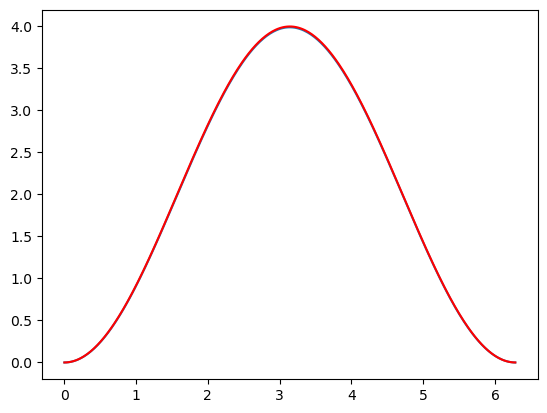

In [51]:
t_grid_A_test = torch.linspace(0.,2*torch.pi,400).view(-1,1)
sol_cluster_A.to('cpu')
boundary_test = 0.
sol = sol_cluster_A(t_grid_A_test,torch.full( t_grid_A_test.shape , boundary_test) )
plt.plot(t_grid_A_test.detach().numpy() , sol.detach().numpy())
plt.plot(t_grid_A_test, -2* np.cos(t_grid_A_test) + boundary_test+2, color = 'red')
plt.show

In [10]:
#save local model A
torch.save(sol_cluster_A, Path(trained_models_address , 'local_A0.pt'))

### Domain B

In [ ]:
#load local model B
sol_cluster_B = torch.load(Path(trained_models_address , 'local_B0.pt'))
sol_cluster_B.eval()

In [ ]:
#define Trainingset on B:
t_grid = torch.linspace(2*torch.pi-0.1 ,4*torch.pi +0.1,2000,requires_grad = True).view(-1,1).to('cuda')
boundary_t = torch.tensor(2*torch.pi, requires_grad = True).view(-1,1).to('cuda')
boundary_values = torch.linspace(-1,1,10, requires_grad = True).to('cuda')
#output on grid:
f_out = torch.zeros(t_grid.shape[0]).to('cuda')
for i in range(t_grid.shape[0]):
  f_out[i] = f(t_grid[i])

#model:
#sol_cluster_B = LocalDeepONet_oneDim(1, 20, 10)
sol_cluster_B.to('cuda')
alpha = 1e-3
beta = 0
optimizer = torch.optim.Adam(sol_cluster_B.parameters(), lr = 1e-3)
for i in range(2000):
  boundary_value_epoch = torch.full( t_grid.shape , boundary_values[i%10].item(), requires_grad = True).to('cuda')
  optimizer.zero_grad()
  loss = D_loc(sol_cluster_B , boundary_t, boundary_value_epoch  , t_grid, f_out , alpha, beta )
  print(f'loss: {loss.item()}')
  loss.backward(retain_graph=True)
  optimizer.step()

<function matplotlib.pyplot.show(close=None, block=None)>

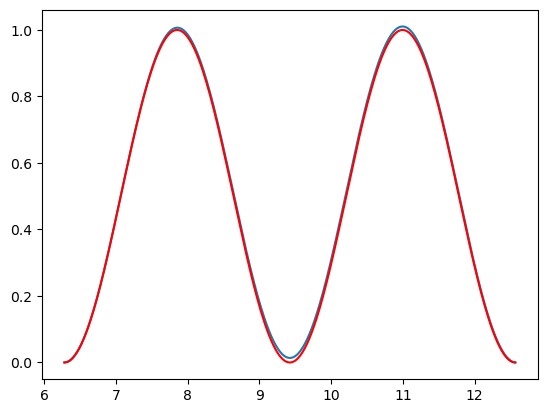

In [61]:
t_grid_B_test = torch.linspace(0.+2*torch.pi ,4*torch.pi,400).view(-1,1)
sol_cluster_B.to('cpu')
boundary_test = 0.

sol = sol_cluster_B(t_grid_B_test,torch.full( t_grid_B_test.shape , boundary_test) )
plt.plot(t_grid_B_test.detach().numpy() , sol.detach().numpy())
plt.plot(t_grid_B_test, (-0.5) * np.cos(2* t_grid_B_test)+0.5+ boundary_test , color = 'red')
plt.show

In [21]:
#save local model B
torch.save(sol_cluster_B, Path(trained_models_address , 'local_B0.pt'))

# Training Loops Global Models

In [7]:
from models_code.AssemblingNetworks.NaiveAssemblingNetwork import NaiveAssemblingNetwork
from models_code.AssemblingNetworks.AssemblingNetwork_non_t_dep import AssemblingNetwork_non_t_dep
from models_code.AssemblingNetworks.ResAssemblingNetwork import ResAssemblingNetwork

In [8]:
sol_cluster_A.to('cuda')
sol_cluster_B.to('cuda')
local_solutions = [sol_cluster_A, sol_cluster_B]

In [15]:
#define Trainingset for AssemblingNetwork:
N_grid = 10000
t_grid = torch.linspace(0. , 40*torch.pi,N_grid,requires_grad = True).view(-1,1)
clust_idx_boundary_t, t_rep_boundary = clustering(torch.tensor([0.]))
boundary_t = torch.tensor(  0., requires_grad = True).view(-1,1)
boundary_rep = torch.tensor(  0., requires_grad = True).view(-1,1)
boundary_clust = torch.tensor(  0., requires_grad = True).view(-1,1)
boundary_value = torch.zeros( (N_grid, 1) )
#output on grid:
f_out = torch.zeros(t_grid.shape[0])
for i in range(t_grid.shape[0]):
  f_out[i] = f(t_grid[i])


rep_grid = torch.rand( (N_grid , 1) )
clust_grid = torch.rand( (N_grid , 1) )


for i in range(N_grid):
  clust_idx, t_rep  = clustering(t_grid[i,0])
  clust_grid[i,0]  = torch.tensor(clust_idx)
  rep_grid[i,0] = torch.tensor(t_rep)

clust_grid.requires_grad = True
rep_grid.requires_grad = True

t_grid = t_grid.to('cuda')
boundary_t = boundary_t.to('cuda')
boundary_rep = boundary_rep.to('cuda')
boundary_clust = boundary_clust.to('cuda')
rep_grid = rep_grid.to('cuda')
clust_grid = clust_grid.to('cuda')
boundary_value = boundary_value.to('cuda')
f_out = f_out.to('cuda')


C:\Users\seand\AppData\Local\Temp\ipykernel_17500\3120289963.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rep_grid[i,0] = torch.tensor(t_rep)


### Naive Assembling

In [ ]:
#load local model A
sol_cluster_A = torch.load(Path(trained_models_address , 'global_naive0.pt'))
sol_cluster_A.eval()

In [ ]:
#boundaryNet model:
local_solutions[0].to('cuda')
local_solutions[1].to('cuda')

my_assemblingNetwork = NaiveAssemblingNetwork( 1,30,15 ).to('cuda')
alpha = 1e-3
beta = 1e-3
optimizer = torch.optim.Adam(my_assemblingNetwork.parameters(), lr = 1e-3)
for i in range(2000): #tqdm(range(1000)):
  optimizer.zero_grad()
  loss = D_glob(my_assemblingNetwork , local_solutions, boundary_t, boundary_rep, boundary_clust, t_grid, rep_grid, clust_grid , boundary_value , f_out,  alpha, beta )
  print(loss.item())
  loss.backward(retain_graph=True)
  optimizer.step()

C:\Users\seand\AppData\Local\Temp\ipykernel_17500\241938015.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rep_grid_test[i,0] = torch.tensor(t_rep_test)


<function matplotlib.pyplot.show(close=None, block=None)>

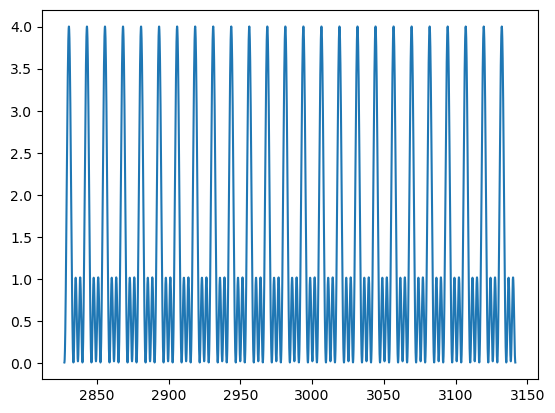

In [12]:
my_assemblingNetwork.to('cpu')
local_solutions[0].to('cpu')
local_solutions[1].to('cpu')

N_grid_test = 10000
t_grid_test = torch.linspace(900*torch.pi , 1000*torch.pi,N_grid_test,requires_grad = True).view(-1,1)
clust_idx_boundary_t, t_rep_boundary = clustering(torch.tensor([0.]))
boundary_t = torch.tensor(  0., requires_grad = True).view(-1,1)
boundary_rep = torch.tensor(  0., requires_grad = True).view(-1,1)
boundary_clust = torch.tensor(  0., requires_grad = True).view(-1,1)
boundary_value = torch.zeros( (N_grid_test, 1) )
#output on grid:
f_out = torch.zeros(t_grid_test.shape[0])
for i in range(t_grid_test.shape[0]):
  f_out[i] = f(t_grid_test[i])


rep_grid_test = torch.rand( (N_grid_test , 1) )
clust_grid_test = torch.rand( (N_grid_test , 1) )


for i in range(N_grid_test):
  clust_idx_test, t_rep_test  = clustering(t_grid_test[i,0])
  clust_grid_test[i,0]  = torch.tensor(clust_idx_test)
  rep_grid_test[i,0] = torch.tensor(t_rep_test)

out,_ = my_assemblingNetwork(t_grid_test, rep_grid_test, clust_grid_test , local_solutions)
out = out.to('cpu').detach().numpy()
plt.plot(t_grid_test.detach().numpy() , out)
plt.show

In [75]:
#save local model B
torch.save(sol_cluster_B, Path(trained_models_address , 'global_naive0.pt'))

### Non time dependent Assembling

In [ ]:
#load local model A
sol_cluster_A = torch.load(Path(trained_models_address , 'global_non_t_dep0.pt'))
sol_cluster_A.eval()

In [ ]:
#boundaryNet model without clustertime dependence:
local_solutions[0].to('cuda')
local_solutions[1].to('cuda')

my_assemblingNetwork = AssemblingNetwork_non_t_dep( 1,30,15 ).to('cuda')
alpha = 1e-3
beta = 1e-3
optimizer = torch.optim.Adam(my_assemblingNetwork.parameters(), lr = 1e-3)
for i in range(2000):
  optimizer.zero_grad()
  loss = D_glob_non_t_dep(my_assemblingNetwork , local_solutions, boundary_rep, boundary_clust,  rep_grid, clust_grid , boundary_value , f_out,  alpha, beta )
  print(loss.item())
  loss.backward(retain_graph=True)
  optimizer.step()

C:\Users\seand\AppData\Local\Temp\ipykernel_17500\2797173196.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rep_grid_test[i,0] = torch.tensor(t_rep_test)


<function matplotlib.pyplot.show(close=None, block=None)>

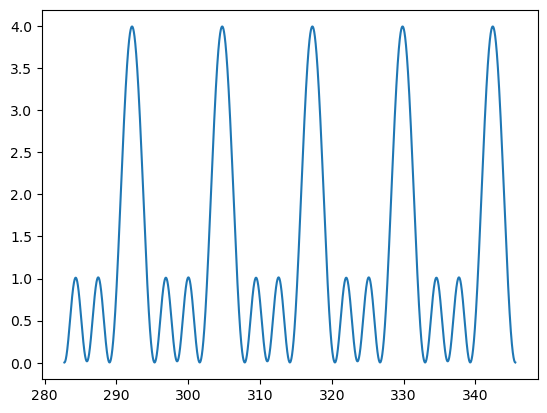

In [22]:
my_assemblingNetwork.to('cpu')
local_solutions[0].to('cpu')
local_solutions[1].to('cpu')

N_grid_test = 10000
t_grid_test = torch.linspace(90*torch.pi , 110*torch.pi,N_grid_test,requires_grad = True).view(-1,1)
clust_idx_boundary_t, t_rep_boundary = clustering(torch.tensor([0.]))
boundary_t = torch.tensor(  0., requires_grad = True).view(-1,1)
boundary_rep = torch.tensor(  0., requires_grad = True).view(-1,1)
boundary_clust = torch.tensor(  0., requires_grad = True).view(-1,1)
boundary_value = torch.zeros( (N_grid_test, 1) )
#output on grid:
f_out = torch.zeros(t_grid_test.shape[0])
for i in range(t_grid_test.shape[0]):
  f_out[i] = f(t_grid_test[i])


rep_grid_test = torch.rand( (N_grid_test , 1) )
clust_grid_test = torch.rand( (N_grid_test , 1) )


for i in range(N_grid_test):
  clust_idx_test, t_rep_test  = clustering(t_grid_test[i,0])
  clust_grid_test[i,0]  = torch.tensor(clust_idx_test)
  rep_grid_test[i,0] = torch.tensor(t_rep_test)

out = my_assemblingNetwork( rep_grid_test,clust_grid_test , local_solutions)[0].detach().numpy()

plt.plot(t_grid_test.detach().numpy() , out)
plt.show

In [23]:
#save local model B
torch.save(sol_cluster_B, Path(trained_models_address , 'global_non_t_dep0.pt'))